In [1]:
import tensorflow as tf
import time, shutil
import numpy as np
import os, collections, sklearn
import joblib

import graph, coarsening
import scipy.sparse as sp

import matplotlib.pyplot as plt
%matplotlib inline

/home/fmonti/.Envs/venv/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Graph definition and coarsening

In [2]:
#Definition of some flags useful later in the code

flags = tf.app.flags
FLAGS = flags.FLAGS

# Graphs.
flags.DEFINE_integer('number_edges', 8, 'Graph: minimum number of edges per vertex.')
flags.DEFINE_string('metric', 'euclidean', 'Graph: similarity measure (between features).')
flags.DEFINE_bool('normalized_laplacian', True, 'Graph Laplacian: normalized.')
flags.DEFINE_integer('coarsening_levels', 4, 'Number of coarsened graphs.')

# Directories.
flags.DEFINE_string('dir_data', 'data_mnist', 'Directory to store data.')

Layer 0: M_0 = |V| = 1024 nodes (240 added), |E| = 3198 edges
Layer 1: M_1 = |V| = 512 nodes (96 added), |E| = 1451 edges
Layer 2: M_2 = |V| = 256 nodes (33 added), |E| = 697 edges
Layer 3: M_3 = |V| = 128 nodes (10 added), |E| = 342 edges
Layer 4: M_4 = |V| = 64 nodes (0 added), |E| = 169 edges
Execution time: 0.36s


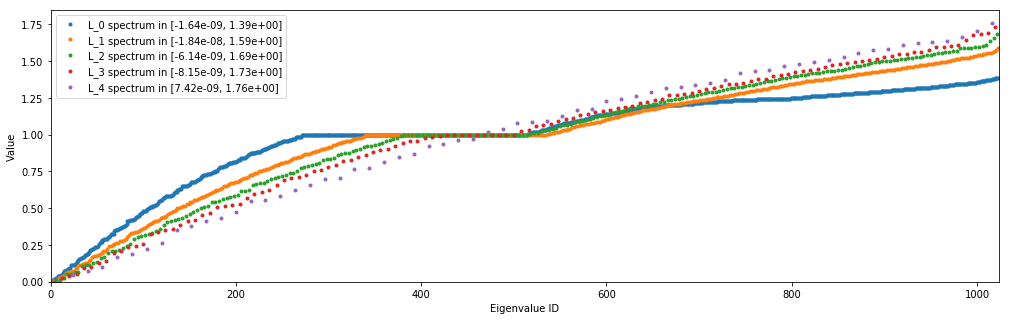

In [3]:
#Here we proceed at computing the original grid where the images live and the various coarsening that are applied
#for each level

def grid_graph(m):
    z = graph.grid(m)
    dist, idx = graph.distance_sklearn_metrics(z, k=FLAGS.number_edges, metric=FLAGS.metric) 
    #dist contains the distance of the 8 nearest neighbors for each node sorted in ascending order
    #idx contains the indexes of the 8 nearest for each node sorted in ascending order by distance

    A = graph.adjacency(dist, idx)
    return A

def coarsen(A, levels):
    graphs, parents = coarsening.metis(A, levels) #Coarsen a graph multiple times using the METIS algorithm. 
                                                  #Everything starts with a random point and then decides how to 
                                                  #combine the points.
                                                  #Construction is done a priori, so we have one graph
                                                  #for all the samples!
                    
                                                  #graphs = list of spare adjacency matrices (it contains in position 
                                                  #          0 the original graph)
                                                  #parents = list of numpy arrays (every array in position i contains 
                                                  #           the mapping from graph i to graph i+1, i.e. the idx of
                                                  #           node i in the coarsed graph) 
    perms = coarsening.compute_perm(parents) #Return a list of indices to reorder the adjacency and data matrices so
                                             #that the union of two neighbors from layer to layer forms a binary tree.
                                             #Fake nodes are appended at the end of the current graph
    laplacians = []
    for i,A in enumerate(graphs):
        M, M = A.shape

        # We remove any possible self-connection.
        A = A.tocoo()
        A.setdiag(0)

        if i < levels: #if we have to pool the graph 
            A = coarsening.perm_adjacency(A, perms[i]) #matrix A is here extended with the fakes nodes
                                                       #in order to do an efficient pooling operation
                                                       #in tensorflow as it was a 1D pooling

        A = A.tocsr()
        A.eliminate_zeros()
        Mnew, Mnew = A.shape
        print('Layer {0}: M_{0} = |V| = {1} nodes ({2} added), |E| = {3} edges'.format(i, Mnew, Mnew-M, A.nnz//2))

        L = graph.laplacian(A, normalized=FLAGS.normalized_laplacian)
        laplacians.append(L)
    return laplacians, perms[0] if len(perms) > 0 else None

t_start = time.time()

np.random.seed(0)
A = grid_graph(28)
L, perm = coarsen(A, FLAGS.coarsening_levels)

print('Execution time: {:.2f}s'.format(time.time() - t_start))

graph.plot_spectrum(L)
del A

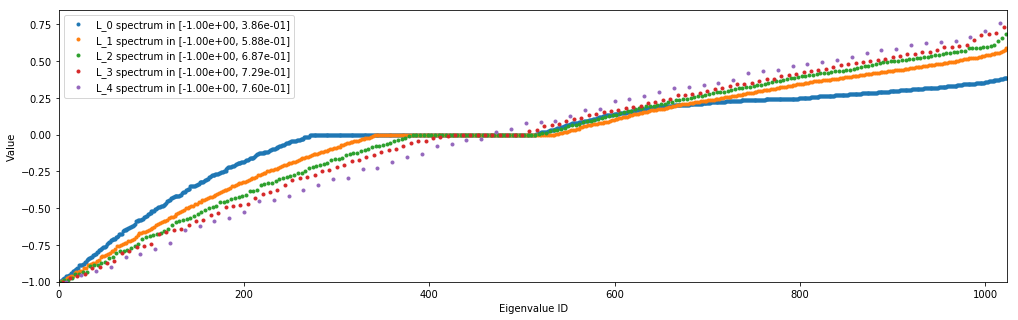

In [4]:
#Normalize Laplacian
L_norm = []
for k in range(len(L)):
    L_norm.append(L[k] - sp.eye(L[k].shape[0]))
graph.plot_spectrum(L_norm, ymin=-1)

# Data loading

In [5]:
#loading of MNIST dataset

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(FLAGS.dir_data, one_hot=False)

train_data = mnist.train.images.astype(np.float32)
val_data = mnist.validation.images.astype(np.float32) #the first 5K samples of the training dataset 
                                                      #are used for validation
test_data = mnist.test.images.astype(np.float32)
train_labels = mnist.train.labels
val_labels = mnist.validation.labels
test_labels = mnist.test.labels

t_start = time.time()
train_data = coarsening.perm_data(train_data, perm)
val_data = coarsening.perm_data(val_data, perm)
test_data = coarsening.perm_data(test_data, perm)
print('Execution time: {:.2f}s'.format(time.time() - t_start))
del perm

Extracting data_mnist/train-images-idx3-ubyte.gz
Extracting data_mnist/train-labels-idx1-ubyte.gz
Extracting data_mnist/t10k-images-idx3-ubyte.gz
Extracting data_mnist/t10k-labels-idx1-ubyte.gz
Execution time: 1.06s


# Model definition

In [29]:
class CayleyNet:
    """
    The neural network model.
    """
    
    #Helper functions used for constructing the model
    def _weight_variable(self, shape, regularization=True, name=""): 
        """Initializer for the weights"""
        
        initial = tf.truncated_normal_initializer(0, 0.1)
        var = tf.get_variable('weights'+name, shape, tf.float32, initializer=initial)
        if regularization: #append the loss of the current variable to the regularization term 
            self.regularizers.append(tf.nn.l2_loss(var))
        return var
    
    def _bias_variable(self, shape, regularization=True):
        """Initializer for the bias"""
        
        initial = tf.constant_initializer(0.1)
        var = tf.get_variable('bias', shape, tf.float32, initializer=initial)
        if regularization:
            self.regularizers.append(tf.nn.l2_loss(var))
        return var
    
    def _h_variable(self, shape, regularization=False, name=''):
        """Initializer for the zoom parameter h"""
        
        initial = tf.random_uniform_initializer()
        var = tf.get_variable('h'+name, shape, tf.float32, initializer=initial)
        if regularization:
            self.regularizers.append(tf.nn.l2_loss(var))
        return var

    def frobenius_norm(self, tensor): 
        """Computes the frobenius norm for a given laplacian"""
        
        square_tensor = tf.square(tensor)
        tensor_sum = tf.reduce_sum(square_tensor)
        frobenius_norm = tf.sqrt(tensor_sum)
        return frobenius_norm
    
    def compute_sparse_D_inv_indices(self, M):
        """Computes the indices required for constructing a sparse version of D^-1."""
        
        idx_main_diag = np.tile(np.expand_dims(np.arange(0, 2*M),1), [1, 2])
        idx_diag_ur = np.concatenate([np.expand_dims(np.arange(0, M),1), np.expand_dims(np.arange(0, M)+M,1)], 1)
        idx_diag_ll = np.concatenate([np.expand_dims(np.arange(0, M)+M,1), np.expand_dims(np.arange(0, M),1)], 1)
        idx = np.concatenate([idx_main_diag, idx_diag_ur, idx_diag_ll], 0)
        return idx  
    
    def compute_sparse_R_indices(self, L_off_diag, M):
        """Computes the indices required for constructing a sparse version of R."""
        
        idx_L = np.asarray(np.where(L_off_diag)).T
        idx_L_sh = idx_L + np.expand_dims(np.asarray([M,M]),0)
        idx = np.concatenate([idx_L, idx_L_sh])
        return idx
    
    def compute_sparse_numerator_projection_indices(self, L, M):
        """Computes the indices required for constructing the numerator projection sparse matrix."""
        
        idx_L = np.asarray(np.where(L)).T
        idx_L_sh = idx_L + np.expand_dims(np.asarray([M,M]),0)
        idx_diag_ur = np.concatenate([np.expand_dims(np.arange(0, M),1), np.expand_dims(np.arange(0, M)+M,1)], 1)
        idx_diag_ll = np.concatenate([np.expand_dims(np.arange(0, M)+M,1), np.expand_dims(np.arange(0, M),1)], 1)
        idx = np.concatenate([idx_L, idx_L_sh, idx_diag_ur, idx_diag_ll])
        return idx
    
    def cayleyConv(self, x, L_np, Fout, K): 
        """Applies chebyshev polynomials over the graph."""
        
        M, Fin = x.get_shape()[1:] # M the number of samples in the images, Fin the number of features
        M, Fin = int(M), int(Fin)
        N = tf.shape(x)[0] # N is the number of images
        
        # Applies cayley transform by means of Jacobi method.
        diag_L_np = np.diag(L_np)  # vector containing the diagonal of L
        L_off_diag_np = L_np - np.diag(diag_L_np) # off-diagonal entries of L 
        
        list_x_pos_exp = [tf.cast(tf.expand_dims(x,0), 'complex64')] # 1 x N x M x F
        
        for iii in range(self.n_h):  # for every zoom parameter we want to use (typically one).
            h = self._h_variable([1,1], regularization=False, name='_h%f' % iii)
            self.list_h.append(h)
            
            # Computes matrices required by Jacobi (https://en.wikipedia.org/wiki/Jacobi_method)
            
            # To make things more efficient we reprent a complex vector of shape M as real vector of shape 2*M
            # where the first M values represent real coefficients while the second M the imaginary ones.
            # All the matrices here defined are computed according to such notation (it allows to use sparse matrices
            # with TF with complex values).
            
            # ************************** COMPUTES numerator projection **************************
            idx = self.compute_sparse_numerator_projection_indices(L_np, M)
            
            vals_L = tf.squeeze(h*L_np[np.where(L_np)])
            vals = tf.concat([vals_L, vals_L, tf.ones([M,]), -tf.ones([M,])], 0)
            
            cayley_op_neg_sp = tf.SparseTensor(idx, vals, [M*2, M*2])
            cayley_op_neg_sp = tf.sparse_reorder(cayley_op_neg_sp)
        
            # ************************** COMPUTES D **************************
            D_real = tf.squeeze(h*diag_L_np)
            D = tf.complex(D_real, tf.ones_like(D_real))
            D_inv = tf.pow(D, -tf.ones_like(D)) # vector of M elements <- diagonal of D^-1
            
            idx = self.compute_sparse_D_inv_indices(M)
            vals = tf.concat([tf.real(D_inv), tf.real(D_inv), -tf.imag(D_inv), tf.imag(D_inv)], 0)
            
            D_inv_ext_sp = tf.SparseTensor(idx, vals, [M*2, M*2])
            D_inv_ext_sp = tf.sparse_reorder(D_inv_ext_sp)
            
            # ************************** COMPUTES R **************************
            idx = self.compute_sparse_R_indices(L_off_diag_np, M)
            
            vals_L = tf.squeeze(h*L_off_diag_np[np.where(L_off_diag_np)])
            vals = tf.concat([vals_L, vals_L], 0)
            
            R_sp = tf.SparseTensor(idx, vals, [M*2, M*2])
            R_sp = tf.sparse_reorder(R_sp)
            
            # Applies Jacobi method
            c_transform = tf.transpose(x, [1,0,2]) # shape = M, N, F
            c_transform = tf.reshape(c_transform, [M, -1]) # shape = M, N*F
            last_sol = tf.concat([c_transform, tf.zeros_like(c_transform)],0)
            for k in range(K):  # for every order of our polynomial
                
                # Jacobi initialization
                b = tf.sparse_tensor_dense_matmul(cayley_op_neg_sp, last_sol) # shape = M, N*F
                a = tf.sparse_tensor_dense_matmul(D_inv_ext_sp, b) # shape = M, N*F
                
                # Jacobi iterations
                cond = lambda i, _: tf.less(i, self.num_jacobi_iter)
                body = lambda i, c_sol: [tf.add(i, 1), a  - tf.sparse_tensor_dense_matmul(D_inv_ext_sp, 
                                                                                          tf.sparse_tensor_dense_matmul(R_sp, c_sol))]
                
                c_sol = tf.while_loop(cond, body, [0, a], parallel_iterations=1, swap_memory=True)
                c_sol = c_sol[-1]
                    
                # Constructs and saves the final complex matrices
                c_sol_complex = tf.complex(c_sol[:M,:], c_sol[M:, :]) #M x N*F
                c_sol_reshaped = tf.reshape(c_sol_complex, [M, -1, Fin])
                c_sol_reshaped = tf.transpose(c_sol_reshaped, [1, 0, 2]) #N x M x F
                list_x_pos_exp.append(tf.expand_dims(c_sol_reshaped,0)) #1 x N x M x Flist_x_pos_exp
                
                last_sol = c_sol
        x_pos_exp = tf.concat(list_x_pos_exp, 0) # shape = n_h*K x N x M x Fin
        x_pos_exp = tf.transpose(x_pos_exp, [1,2,0,3])  #N x M x n_h*K x Fin
        x_pos_exp = tf.reshape(x_pos_exp, [N*M, -1]) #N*M x 2*K*Fin
        
        real_conv_weights = self._weight_variable([Fin*(self.n_h*K+1), Fout], regularization=False, name='_real')#tf.ones([Fin*(self.n_h*K+1), Fout])#self._weight_variable([Fin*(self.n_h*K+1), Fout], regularization=False, name='_real')
        imag_conv_weights = self._weight_variable([Fin*(self.n_h*K+1), Fout], regularization=False, name='_imag')#tf.ones([Fin*(self.n_h*K+1), Fout])#self._weight_variable([Fin*(self.n_h*K+1), Fout], regularization=False, name='_imag')
        
        W_pos_exp = tf.complex(real_conv_weights, -imag_conv_weights)
        
        x_pos_exp_filt = tf.matmul(x_pos_exp, W_pos_exp)
        
        x_filt = 2*tf.real(x_pos_exp_filt)
        return tf.reshape(x_filt, [N, M, Fout])


    def b1relu(self, x): #sums a bias and applies relu
        """Bias and ReLU. One bias per filter."""
        N, M, F = x.get_shape()
        b = self._bias_variable([1, 1, int(F)], regularization=False)
        return tf.nn.relu(x + b) #add the bias to the convolutive layer


    def mpool1(self, x, p): #efficient pooling realized thanks to the reordering of the laplacians we have done a priori
        """Max pooling of size p. Should be a power of 2."""
        if p > 1:
            x = tf.expand_dims(x, 3)  # N x M x F x 1
            x = tf.nn.max_pool(x, ksize=[1,p,1,1], strides=[1,p,1,1], padding='SAME')
            return tf.squeeze(x, [3])  # N x M/p x F
        else:
            return x
    

    def b1relu(self, x): #sums a bias and applies relu
        """Bias and ReLU. One bias per filter."""
        N, M, F = x.get_shape()
        b = self._bias_variable([1, 1, int(F)], regularization=False)
        return tf.nn.relu(x + b) #add the bias to the convolutive layer


    def mpool1(self, x, p): #efficient pooling realized thanks to the reordering of the laplacians we have done a priori
        """Max pooling of size p. Should be a power of 2."""
        if p > 1:
            x = tf.expand_dims(x, 3)  # N x M x F x 1
            x = tf.nn.max_pool(x, ksize=[1,p,1,1], strides=[1,p,1,1], padding='SAME')
            return tf.squeeze(x, [3])  # N x M/p x F
        else:
            return x

    def fc(self, x, Mout, relu=True):
        """Fully connected layer with Mout features."""
        N, Min = x.get_shape()
        W = self._weight_variable([int(Min), Mout], regularization=True)
        b = self._bias_variable([Mout], regularization=True)
        x = tf.matmul(x, W) + b
        return tf.nn.relu(x) if relu else x
    
    #function used for extracting the result of our model
    def _inference(self, x, dropout): #definition of the model
        
        # Graph convolutional layers.
        x = tf.expand_dims(x, 2)  # N x M x F=1
        j = 0
        self.list_h = list()
        for i in range(len(self.p)):
            with tf.variable_scope('cgconv{}'.format(i+1)):
                with tf.name_scope('filter'):
                    x = self.cayleyConv(x, self.L_np[i*2], self.F[i], self.K[i])
                    if (i==0):
                        self.debug = x
                with tf.name_scope('bias_relu'):
                    x = self.b1relu(tf.cast(tf.real(x), 'float32'))
                with tf.name_scope('pooling'):
                    x = self.mpool1(x, self.p[i])
                    
            j += int(np.log2(self.p[i])) if self.p[i] > 1 else 0
        
        # Fully connected hidden layers.
        _, M, F = x.get_shape()
        x = tf.reshape(x, [-1, int(M*F)])  # N x M
        for i,M in enumerate(self.M[:-1]): #apply a fully connected layer for each layer defined in M
                                           #(we discard the last value in M since it contains the number of classes we have
                                           #to predict)
            with tf.variable_scope('fc{}'.format(i+1)):
                x = self.fc(x, M)
                x = tf.nn.dropout(x, dropout)
        
        # Logits linear layer, i.e. softmax without normalization.
        with tf.variable_scope('logits'):
            x = self.fc(x, self.M[-1], relu=False)
        return x
    
    def __init__(self, p, K, F, M, M_0, batch_size, num_jacobi_iter, L,
                 decay_steps, decay_rate, learning_rate=1e-4, momentum=0.9, regularization=5e-4, clip_norm=1e1,
                 idx_gpu = '/gpu:0'):
        self.regularizers = list() #list of regularization l2 loss for multiple variables
        self.n_h = 1
        self.num_jacobi_iter = num_jacobi_iter
        self.p = p #dimensions of the pooling layers
        self.K = K #List of polynomial orders, i.e. filter sizes or number of hops
        self.F = F #Number of features of convolutional layers
        
        self.M = M #Number of neurons in fully connected layers
        
        self.M_0 = M_0 #number of elements in the first graph 
        
        self.batch_size = batch_size
        
        #definition of some learning parameters
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate
        self.learning_rate = learning_rate
        self.regularization = regularization
        
        with tf.Graph().as_default() as g:
                self.graph = g
                tf.set_random_seed(0)
                with tf.device(idx_gpu):
                        #definition of placeholders
                        self.L_np = [c_L.toarray().astype('float32') for c_L in L]
                        self.ph_data = tf.placeholder(tf.float32, (self.batch_size, M_0), 'data')
                        self.ph_labels = tf.placeholder(tf.int32, (self.batch_size), 'labels')
                        self.ph_dropout = tf.placeholder(tf.float32, (), 'dropout')
                    
                        #Model construction
                        self.logits = self._inference(self.ph_data, self.ph_dropout)
                        
                        #Definition of the loss function
                        with tf.name_scope('loss'):
                            self.cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.logits, labels=self.ph_labels)
                            self.cross_entropy = tf.reduce_mean(self.cross_entropy)
                        with tf.name_scope('regularization'):
                            self.regularization *= tf.add_n(self.regularizers)
                        self.loss = self.cross_entropy + self.regularization
                        
                        #Solver Definition
                        with tf.name_scope('training'):
                            # Learning rate.
                            global_step = tf.Variable(0, name='global_step', trainable=False) #used for counting how many iterations we have done
                            if decay_rate != 1: #applies an exponential decay of the lr wrt the number of iterations done
                                learning_rate = tf.train.exponential_decay(
                                        learning_rate, global_step, decay_steps, decay_rate, staircase=True)
                            # Optimizer.
                            if momentum == 0:
                                optimizer = tf.train.GradientDescentOptimizer(learning_rate)
                            else: #applies momentum for increasing the robustness of the gradient 
                                optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
                            #grads = optimizer.compute_gradients(self.loss)
                            tvars = tf.trainable_variables()
                            #grads, _ = tf.clip_by_global_norm(tf.gradients(self.loss, tvars), clip_norm)
                            grads, variables = zip(*optimizer.compute_gradients(self.loss))
                            grads, _ = tf.clip_by_global_norm(grads, clip_norm)
                            self.op_gradients = optimizer.apply_gradients(zip(grads, variables), 
                                                                          global_step=global_step)
                            
                        #Computation of the norm gradients (useful for debugging)
                        self.var_grad = tf.gradients(self.loss, tf.trainable_variables())
                        self.norm_grad = self.frobenius_norm(tf.concat([tf.reshape(g, [-1]) for g in self.var_grad], 0))

                        #Extraction of the predictions and computation of accuracy
                        self.predictions = tf.cast(tf.argmax(self.logits, dimension=1), tf.int32)
                        self.accuracy = 100 * tf.contrib.metrics.accuracy(self.predictions, self.ph_labels)
        
                        # Create a session for running Ops on the Graph.
                        config = tf.ConfigProto(allow_soft_placement = True)
                        config.gpu_options.allow_growth = True
                        self.session = tf.Session(config=config)

                        # Run the Op to initialize the variables.
                        init = tf.global_variables_initializer()
                        self.session.run(init)

# Training & testing

In [30]:
#Convolutional parameters
p = [4, 4]   # Dimensions of the pooling layers
K = [12, 12] # List of polynomial orders, i.e. filter sizes or number of hops
F = [32, 64] # Number of features of convolutional layers

#FC parameters
C = max(train_labels) + 1 # Number of classes we have
M = [512, C] # Number of neurons in fully connected layers

#Solver parameters
batch_size = 100
decay_steps = train_data.shape[0] / batch_size # number of steps to do before decreasing the learning rate
decay_rate = 0.95
learning_rate = 0.01
momentum = 0.9
regularization = 5e-4

# Definition of keep probabilities for dropout layers
dropout_training = 0.5
dropout_val_test = 1.0

num_jacobi_iter = 10

In [31]:
# Construction of the learning obj
M_0 = L[0].shape[0] # number of elements in the first graph
learning_obj = CayleyNet(p, K, F, M, M_0, batch_size, num_jacobi_iter, L,
                         decay_steps, decay_rate,
                         learning_rate=learning_rate, regularization=regularization,
                         momentum=momentum)#, clip_norm=100)

# definition of overall number of training iterations and validation frequency
num_iter_val = 600
num_total_iter_training = 21000

num_iter = 0

list_training_loss = list()
list_training_norm_grad = list()
list_val_accuracy = list()

In [ ]:
#training and validation
indices = collections.deque() # queue containing a permutation of the training indexes
for k in range(num_iter, num_total_iter_training):

    #Construction of the training batch
    if len(indices) < batch_size: # Be sure to have used all the samples before using one a second time.
        indices.extend(np.random.permutation(train_data.shape[0])) #reinitialize the queue of indices
    idx = [indices.popleft() for i in range(batch_size)] #extract the current batch of samples

    #data extraction
    batch_data, batch_labels = train_data[idx,:], train_labels[idx] 

    feed_dict = {learning_obj.ph_data: batch_data, 
                 learning_obj.ph_labels: batch_labels, 
                 learning_obj.ph_dropout: dropout_training}

    #Training
    tic = time.time()
    _, current_training_loss, norm_grad = learning_obj.session.run([learning_obj.op_gradients, 
                                                                    learning_obj.loss, 
                                                                    learning_obj.norm_grad], feed_dict = feed_dict) 
    training_time = time.time() - tic

    list_training_loss.append(current_training_loss)
    list_training_norm_grad.append(norm_grad)
    if (np.mod(num_iter, num_iter_val)==0): #validation
        msg = "[TRN] iter = %03i, cost = %3.2e, |grad| = %.2e (%3.2es)" \
                    % (num_iter, list_training_loss[-1], list_training_norm_grad[-1], training_time)
        print msg

        #Validation Code
        tic = time.time()
        val_accuracy = 0
        for begin in range(0, val_data.shape[0], batch_size):
            end = begin + batch_size
            end = min([end, val_data.shape[0]])

            #data extraction
            batch_data = np.zeros((end-begin, val_data.shape[1]))
            batch_data = val_data[begin:end,:]
            batch_labels = np.zeros(batch_size)
            batch_labels[:end-begin] = val_labels[begin:end]

            feed_dict = {learning_obj.ph_data: batch_data, 
                         learning_obj.ph_labels: batch_labels,
                         learning_obj.ph_dropout: dropout_val_test}

            batch_accuracy = learning_obj.session.run(learning_obj.accuracy, feed_dict)
            val_accuracy += batch_accuracy*batch_data.shape[0]
        val_accuracy = val_accuracy/val_data.shape[0]

        val_time = time.time() - tic
        msg = "[VAL] iter = %03i, acc = %4.2f (%3.2es)" % (num_iter, val_accuracy, val_time)
        print msg
    num_iter += 1

[TRN] iter = 000, cost = 1.84e+01, |grad| = 5.39e+01 (2.45e+00s)
[VAL] iter = 000, acc = 10.56 (8.10e+00s)
[TRN] iter = 600, cost = 4.21e+00, |grad| = 2.15e+00 (1.07e+00s)
[VAL] iter = 600, acc = 96.68 (7.84e+00s)


In [34]:
#Test code
tic = time.time()
test_accuracy = 0
for begin in range(0, test_data.shape[0], batch_size):
    end = begin + batch_size
    end = min([end, test_data.shape[0]])

    batch_data = np.zeros((end-begin, test_data.shape[1]))
    batch_data = test_data[begin:end,:]

    feed_dict = {learning_obj.ph_data: batch_data, learning_obj.ph_dropout: 1}

    batch_labels = np.zeros(batch_size)
    batch_labels[:end-begin] = test_labels[begin:end]
    feed_dict[learning_obj.ph_labels] = batch_labels

    batch_accuracy = learning_obj.session.run(learning_obj.accuracy, feed_dict)
    test_accuracy += batch_accuracy*batch_data.shape[0]
test_accuracy = test_accuracy/test_data.shape[0]
test_time = time.time() - tic
msg = "[TST] iter = %03i, acc = %4.2f (%3.2es)" % (num_iter, test_accuracy, test_time)
print msg

[TST] iter = 21000, acc = 99.03 (1.62e+01s)
